# Outline

This notebook provides a 
* general idea of a paper,
* description of a game
* analysis of the data available


## General idea of a paper
I want to understand the effect of certain sentiments in communication on the performance of a team. This is important because people are social creatures and spend a significant amount of time performing a job in teams. In the case of jobs, a team is a group of colleagues and performance is their KPIs. 

However, it is difficult to get the data on all the communication between team members and quantify the performance. That is why I am going to focus on the Dota 2, a multiplayer online battle arena (MOBA) video game. In this game, people communicate and accomplish tasks in a team, which is similar to the work environment. Due to the recent pandemic, remote jobs are getting popular, which makes work in teams look more similar to the players of Dota 2. Workers shift to using chats instead of verbal communication.


## Description of a game
Dota 2 is played in matches between two teams of five players, with each team occupying and defending their own separate base on the map. Each of the ten players independently controls a powerful character known as a "hero" that all have unique abilities and differing styles of play. During a match players collect experience points (XP) and buy items (with gold) for their heroes to successfully defeat the opposing team's heroes in player versus player combat. A team wins by being the first to destroy the other team's "Ancient", a large structure located within their base. Ancients are located in the left bottom and right upper corners. 

<img src=https://i.imgur.com/iqE4fxr.png width="700">

To destroy the ancient players need XP to level up a hero and gold to buy inventory. For any kill, a hero gains XP and gold. There are three types of characters a player can kill: 
1. creeps, 
2. neutrals, 
3. other heroes. 

Creeps are non-player characters (NPC) that regularly march from each team's Ancient towards the other Ancient. Creeps march only by lanes (top, mid, bottom) and they are considered to be pawns of each team. Usually heroes help friendly creeps to kill the enemy creeps. 

Neutral creeps are NPCs that appear in the jungle. Unlike creeps, they are not playing for any team (hence, the name neutral) and don't move unless get attacked. Heroes can "switch" from lanes to the jungle and kill neutral creeps.

Heroes are human players. There is a total of 10 heroes (10 players), 5 for each team. Sometimes, when several heroes from the opposing teams meet they can decide to fight and get gold and XP. If a hero dies, it appears 

Overall, players are either killing creeps on lanes, killing neutrals in jungle, or killing heroes. This strategy lasts until one of the team gains enough gold and XP to destroy the ancient.

## Analysis of the data available

In [3]:
import pandas as pd
import numpy as np

In [9]:
# teamfights data for each player 
tf_player = pd.read_csv('../Data/Original/teamfights_players.csv')

# teamfights timings
tf = pd.read_csv('../Data/Original/teamfights.csv')

# player info for each minute
player_time = pd.read_csv('../Data/Original/player_time.csv')

# chat data
chat = pd.read_csv('../Data/Original/chat.csv')

# player ratings
player_ratings = pd.read_csv('../Data/Original/player_ratings.csv')

# player info for the match
player = pd.read_csv('../Data/Original/players.csv')

# match information
match = pd.read_csv('../Data/Original/match.csv')

# account id info  
match_outcomes = pd.read_csv('../Data/Original/match_outcomes.csv')

In [11]:
match.head()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


Let's depict the histogram for the duration of matches 

In [12]:
match['duration_min'] = match['duration']/60 

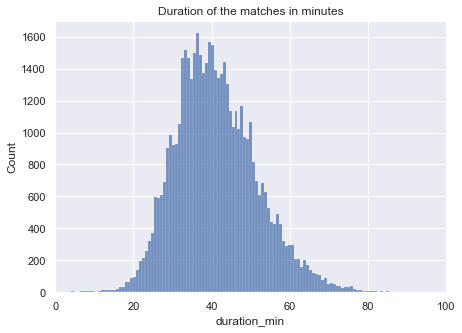

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(7, 5)})
fig, ax = plt.subplots()
sns.histplot(match.duration_min).set_title('Duration of the matches in minutes')
ax.set_xlim(0,100)
#ax.set_xticks(range(0,100))
plt.show()

As we can see, the duration of a match ranges from 30 to 50 minutes 

In [4]:
# number of games under analysis
n_observations = 100 

### Add a start column to tf_player dataframe

In [5]:
# create empty 
tf_player["start"] = ""

# event_times for games
event_times = tf.start

In [6]:
def n_times(v,n):
    for i in range(n):
        yield v

event_times = [i for j in event_times for i in n_times(j,10)]

In [7]:
tf_player["start"] = np.array(event_times)

In [8]:
tf_player['radiant'] = np.where(tf_player['player_slot']<= 5, 1, 0)

### Get sum of gold by each team

In [9]:
x = tf_player.groupby(['match_id', 'start', 'radiant']).sum()['gold_delta']

In [10]:
radiant_gold = x.loc[:,:,1]
dire_gold = x.loc[:,:,0]

In [11]:
tf['radiant_gold'] = np.array(radiant_gold)
tf['dire_gold'] = np.array(dire_gold)

In [12]:
tf['delta_gold'] = tf['radiant_gold'] - tf['dire_gold']

In [13]:
tf.head()

,match_id,start,end,last_death,deaths,radiant_gold,dire_gold,delta_gold
0,0,220,252,237,3,632,790,-158
1,0,429,475,460,3,1929,345,1584
2,0,900,936,921,3,3145,-506,3651
3,0,1284,1328,1313,3,1872,-112,1984
4,0,1614,1666,1651,5,1768,2164,-396


### Add player in-game characteristics to the tf

In [14]:
# round start time by minute
tf['times'] = (tf.start//60)*60
tf['times']= np.where(tf['times']< 0, 0, tf['times'])

In [15]:
tf2 = pd.merge(tf, player_time,  how='left', left_on=['match_id','times'], right_on = ['match_id','times'])

In [16]:
tf2.head()

,match_id,start,end,last_death,deaths,radiant_gold,dire_gold,delta_gold,times,gold_t_0,...,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
0,0,220,252,237,3,632,790,-158,180,683,...,842,958,16,1135,300,0,210,1290,8,527
1,0,429,475,460,3,1929,345,1584,420,1257,...,2033,2652,47,3111,700,0,241,3033,28,1329
2,0,900,936,921,3,3145,-506,3651,900,3324,...,4472,6534,114,7788,1767,6,1486,6470,60,3822
3,0,1284,1328,1313,3,1872,-112,1984,1260,5019,...,5583,8777,147,9713,2606,8,1929,9637,87,6372
4,0,1614,1666,1651,5,1768,2164,-396,1560,6394,...,6892,11091,171,12333,3678,15,3392,12017,108,8150


### Add chat to tf2

In [17]:
# change slot accordingly
chat.loc[chat['slot'] ==5 , 'slot'] = 128
chat.loc[chat['slot'] ==6 , 'slot'] = 129
chat.loc[chat['slot'] ==7 , 'slot'] = 130
chat.loc[chat['slot'] ==8 , 'slot'] = 131
chat.loc[chat['slot'] ==9 , 'slot'] = 132

In [18]:
for i in range(50000):
    start = tf2[tf2.match_id == i]['start'].to_list()
    for k in range(len(start)):
        chat.loc[(chat['match_id']==i)& (chat['time']<start[len(start)-k-1]), 'start'] = start[len(start)-k-1]

KeyboardInterrupt: 

### Only first 20,000 games

In [ ]:
chat = chat[chat.match_id<20000]

In [ ]:
chat = chat.dropna()

In [ ]:
chat = chat.groupby(['match_id', 'start', 'slot'])['key'].apply(' '.join).reset_index()

In [ ]:
chat.head()

### Predict toxicity

In [ ]:
import pickle

In [ ]:
# load model
model = pickle.load(open('../toxic_classifier/log_model.pkl', 'rb'))

In [ ]:
import os
import re
import nltk
import string
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer 

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load the stopword list provided by the NLTK library
stop_words = stopwords.words('english')

In [ ]:
def preprocessing_text(text):
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text) #remove all non‐alphanumeric characters except white space
    text = re.sub("(.)\\1{2,}", "\\1", text) #replace 3+ consecutive letters to 1 (loooovvvve -> love)
    text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", text) # remove emails
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , text) # remove urls
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in stop_words]
    tokens = [token for token in tokens if not any(c.isdigit() for c in token)] #remove everything containing digits
    lemmatizer = WordNetLemmatizer()
    tokens_lematized = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens_lematized)
    return preprocessed_text

In [ ]:
with open("../toxic_classifier/comment_data.pkl", "rb") as fp:   # Unpickling
    df = pickle.load(fp)

In [ ]:
vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit_transform(df.comment_text)

In [ ]:
def get_pred(s):
    x = []
    x.append(s)
    x[0] = preprocessing_text(x[0])
    vec = vectorizer.transform(x)
    label = model.predict(vec)[0]
    return label

In [ ]:
chat['toxic'] = chat['key'].apply(lambda x: get_pred(x))

In [ ]:
chat

In [ ]:
chat

In [ ]:
chat.pivot(columns='slot', values=['key'])

In [ ]:
chat

In [ ]:
chat[chat.match_id==19999]

In [ ]:
chat.to_csv('../../Data/Modified/chat_modified_v1.csv')

In [ ]:
chat.loc[(chat['match_id']==0)& (chat['time']<start[len(start)-0-1]), 'start'] = start[len(start)-0-1]

In [ ]:
tf2[tf2.match_id == 1000]

In [ ]:
chat[chat.match_id==20000]

In [ ]:
start = tf2[tf2.match_id == 0]['start']

In [ ]:
start[0]

In [ ]:
chat

In [ ]:
chat.loc[(chat['match_id']==0)& (chat['time']<start[len(start)-0]), 'start'] = start[len(start)-0]

In [ ]:
start

In [ ]:
start[0]

In [ ]:
start[len(start)-1]

In [ ]:
for k in range(len(start)):
    print(start[len(start)-1-k])

In [ ]:
chat

In [ ]:
for i in range()

In [ ]:
chat[chat.match_id == 0]

In [ ]:
chat.slot.unique()

In [ ]:
chat[chat['slot']==-9]

In [ ]:
chat.at[652287,'slot']=3

In [ ]:
chat[chat.match_id == 22654]

In [ ]:
player_time

In [ ]:
for i in columns_to_create:
    tf[i] = ""
    for k in range(len(tf)):
        tf.loc[k,i] = player_time.loc[player_time['match_id'] == tf.loc[k].match_id, ('times','lh_t_1')].loc[player_time['times'] == tf.loc[k].times, 'lh_t_1'].iloc[0]


In [ ]:
tf.loc[k].times

In [ ]:
tf.loc[k].match_id

In [ ]:
tf.loc[0,i] = 2

In [ ]:
tf.loc[tf['A'] > 2, 'B'] = new_val

In [ ]:
i

In [ ]:
tf[tf.match_id == 23]

In [ ]:
tf.times.unique()

In [ ]:
player_time.times.unique()

In [ ]:
player_time[player_time.match_id==23]

In [ ]:
tf

In [ ]:
tf.loc[0].i = player_time.loc[player_time['match_id'] == tf.loc[k].match_id, ('times','lh_t_1')].loc[player_time['times'] == tf.loc[k].times, 'lh_t_1'].iloc[0]

In [ ]:
player_time.loc[player_time['match_id'] == tf.loc[k].match_id, ('times','lh_t_1')].loc[player_time['times'] == tf.loc[k].times, 'lh_t_1'].iloc[0]

In [ ]:
tf.loc[0][i]

In [ ]:
tf

In [ ]:
event_times

In [ ]:
player_time.loc[player_time['match_id'] == 0, ('times','lh_t_1')].loc[player_time['times'] == 120, 'lh_t_1'].iloc[0]

In [ ]:
player_time.loc[idx]['lh_t_0']

In [ ]:
idx = player_time.index[(player_time.match_id ==0) & (player_time.times == 60)].tolist()[0]

In [ ]:
player_time

In [ ]:
event_times

In [ ]:
list(player_time.columns)

In [ ]:
for i in range(n_observations):
    # event_times for game i
    event_times = tf[tf.match_id == i].start
    
    # for each event_time, 
    for k in range(len(event_times)):
        for j in range(10):
            tf_player.at[10*k + j,'start'] = event_times.iloc[k]

In [ ]:
event_times = tf[tf.match_id == 3].start

In [ ]:
event_times = tf.start
len(event_times)

In [ ]:
len(tf_player)

In [ ]:
x = tf[tf.match_id == 0]
y = x.start
y

In [ ]:
tf_player.head()

In [ ]:
tf_player.groupby(['match_id', 'start']).mean()

In [ ]:
tf_player.at[0,'start']=10

In [ ]:
set_value?df.at[4, 'B']